In [1]:
import pynbody
import numpy as np
import matplotlib.pyplot as plt

f00=pynbody.load("snapshot_000")
f01=pynbody.load("snapshot_009")
f02=pynbody.load("snapshot_019")
f03=pynbody.load("snapshot_029")
f04=pynbody.load("snapshot_039")
f05=pynbody.load("snapshot_049")
f06=pynbody.load("snapshot_059")
f07=pynbody.load("snapshot_069")
f08=pynbody.load("snapshot_079")
f09=pynbody.load("snapshot_089")
f10=pynbody.load("snapshot_099")

f=[f00,f01,f02,f03,f04,f05,f06,f07,f08,f09,f10]

# Boltzmann constant
kB=pynbody.array.SimArray(np.zeros(1))
kB[0]=1.38e-23
kB.sim=f10
kB.units='J K**-1'
# A simpler way?
    
# Planck constant
h=pynbody.array.SimArray(np.zeros(1))
h[0]=6.63e-34
h.sim=f10
h.units='J s'

np.random.seed(57)
normalize=np.random.normal(size=(len(f10),3))

In [2]:
def entropy_iso(f):
    '''
    f is a snapshot
    returns SimArray of entropy density and entropy
    '''
    
    pynbody.config['sph']['smooth-particles']=256
    
    
    ###
    density=f.dm['rho']
    print('The density has been calculated')
    ###
    
    ######################################################################
    # Normalization Process

    norm1=f.dm.kdtree.sph_mean(normalize)
    norm2=f.dm.kdtree.sph_mean((normalize-norm1)**2)
    
    nx=norm2[:,0]
    ny=norm2[:,1]
    nz=norm2[:,2]
    
    norm=(nx+ny+nz)/3
    
    ######################################################################
    # Velocity Dispersion
    
    offset=np.mean(f.dm['vel'].in_units('m s**-1'))
    vel=f.dm['vel'].in_units('m s**-1')-offset
    
    vel_disp=f.dm.kdtree.sph_mean((vel-f.dm.kdtree.sph_mean(vel))**2)
    
    vx_disp=vel_disp[:,0]
    vy_disp=vel_disp[:,1]
    vz_disp=vel_disp[:,2]

    v_disp=(vx_disp+vy_disp+vz_disp)/3
    
    v_disp=v_disp/norm
    print('the velocity dispersions has been calculated')

    ######################################################################
    # Scaling Process
    # Adopt a value of 40Gev for DM particles(Geringer-Sameth & Koushiappas 2011)
    
    mass_dm=pynbody.array.SimArray(np.random.rand(1))
    mass_dm[0]=40000
    mass_dm.sim=f
    mass_dm.units='MeV c**-2'
    
    ######################################################################
    # Scaled Number density
    
    n_density=f.dm['rho'].in_units('kg m**-3')/mass_dm.in_units('kg')
    
    ######################################################################
    # Sackur-Tetrode Equation
    
    a=np.sqrt(v_disp.in_units('m**2 s**-2'))**3/n_density
    b=a*((2*np.pi)**(3/2))*(mass_dm.in_units('kg')**3)/(h**3)*(np.e**(5/2))
    sv=kB*n_density*np.log(b.in_units('1'))
    
    ######################################################################
    # Entropy
    
    volume=mass_dm/f.dm['rho']
    S=volume*sv
    
    ######################################################################
    # Storing
    
    #  f.dm['Q_iso']=1/a*mass_dm.in_units('kg')
    f.dm['S_iso']=S
    # f.dm['sv_iso']=sv

In [3]:
def entropy_ani(f):
    '''
    f is a snapshot
    returns SimArray of entropy density and entropy
    '''
    
    pynbody.config['sph']['smooth-particles']=256
    
    ###
    density=f.dm['rho']
    print('The density has been calculated')
    ###
    
    ######################################################################
    # Normalization Process
    
    dnorm=normalize-f.dm.kdtree.sph_mean(normalize)
    
    dnormx=dnorm[:,0]
    dnormy=dnorm[:,1]
    dnormz=dnorm[:,2]
    
    n2_xx=f.dm.kdtree.sph_mean(dnormx**2)
    n2_yy=f.dm.kdtree.sph_mean(dnormy**2)
    n2_zz=f.dm.kdtree.sph_mean(dnormz**2)
    
    n2_xy=f.dm.kdtree.sph_mean(dnormx*dnormy)
    n2_yz=f.dm.kdtree.sph_mean(dnormy*dnormz)
    n2_zx=f.dm.kdtree.sph_mean(dnormz*dnormx)
    
    norm6=n2_xx*(n2_yy*n2_zz-n2_yz**2)-n2_xy*(n2_xy*n2_zz-n2_yz*n2_zx)+n2_zx*(n2_xy*n2_yz-n2_yy*n2_zx)
    norm=norm6**(1/3)
    
    ######################################################################
    # Velocity Dispersion
    
    offset=np.mean(f.dm['vel'].in_units('m s**-1'))
    vel=f.dm['vel'].in_units('m s**-1')-offset
    
    dvel=vel-f.dm.kdtree.sph_mean(vel)
    dvx=dvel[:,0]
    dvy=dvel[:,1]
    dvz=dvel[:,2]
    
    disp_xx=f.dm.kdtree.sph_mean(dvx**2)
    disp_yy=f.dm.kdtree.sph_mean(dvy**2)
    disp_zz=f.dm.kdtree.sph_mean(dvz**2)
    
    disp_xy=f.dm.kdtree.sph_mean(dvx*dvy)
    disp_yz=f.dm.kdtree.sph_mean(dvy*dvz)
    disp_zx=f.dm.kdtree.sph_mean(dvz*dvx)
    
    det_disp=disp_xx*(disp_yy*disp_zz-disp_yz**2)-disp_xy*(disp_xy*disp_zz-disp_yz*disp_zx)+disp_zx*(disp_xy*disp_yz-disp_yy*disp_zx)
    det=det_disp**(1/3)
    
    det=det/norm
    det.units='m**2 s**-2'
    
    print('the velocity dispersions has been calculated')

    ######################################################################
    # Scaling Process
    # Adopt a value of 40Gev for DM particles(Geringer-Sameth & Koushiappas 2011)
    
    mass_dm=pynbody.array.SimArray(np.random.rand(1))
    mass_dm[0]=40000
    mass_dm.sim=f
    mass_dm.units='MeV c**-2'
    
    ######################################################################
    # Scaled Number density
    
    n_density=f.dm['rho'].in_units('kg m**-3')/mass_dm.in_units('kg')
    
    ######################################################################
    # Sackur-Tetrode Equation
    
    c=np.sqrt(det.in_units('m**2 s**-2'))**3/n_density.in_units('m**-3')
    d=((2*np.pi)**(3/2))*(np.e**(5/2))*(mass_dm.in_units('kg')**3)/(h**3)*c
    d.units='1'
    sv=kB*n_density*np.log(d.in_units('1'))
    
    ######################################################################
    # Entropy
    
    volume=mass_dm/f.dm['rho']
    S=volume*sv
    
    ######################################################################
    # Storing
    
    # f.dm['Q_ani']=1/c*mass_dm.in_units('kg')
    f.dm['S_ani']=S
    # f.dm['sv_ani']=sv

In [4]:
for i in range(11):
    entropy_iso(f[i])
    entropy_ani(f[i])
    print('This is the',i,'th snapshot')

The density has been calculated
the velocity dispersions has been calculated
The density has been calculated
the velocity dispersions has been calculated
This is the 0 th snapshot
The density has been calculated
the velocity dispersions has been calculated
The density has been calculated
the velocity dispersions has been calculated
This is the 1 th snapshot
The density has been calculated
the velocity dispersions has been calculated
The density has been calculated
the velocity dispersions has been calculated
This is the 2 th snapshot
The density has been calculated
the velocity dispersions has been calculated
The density has been calculated
the velocity dispersions has been calculated
This is the 3 th snapshot
The density has been calculated
the velocity dispersions has been calculated
The density has been calculated
the velocity dispersions has been calculated
This is the 4 th snapshot
The density has been calculated
the velocity dispersions has been calculated
The density has been ca

In [5]:
Stot_iso=np.zeros(11)
Stot_ani=np.zeros(11)

for i in range(11):
    Stot_iso[i]=float(np.sum(f[i].dm['S_iso'].in_units('J K**-1')))
    
for i in range(11):
    Stot_ani[i]=float(np.sum(f[i].dm['S_ani'].in_units('J K**-1')))

In [6]:
tbar=pynbody.array.SimArray(np.zeros(1))
tbar[0]=1
tbar.sim=f10
tbar.units='s Mpc km**-1'

Store=np.zeros((11,2))

for i in range(11):
    Store[i,0]=float(f[i].properties['time'])*(f[i].properties['a']**(1/2))/f[i].properties['h']*float(tbar.in_units('Gyr'))
    Store[i,1]=float(f[i].properties['boxsize'])*f[i].properties['a']/f[i].properties['h']

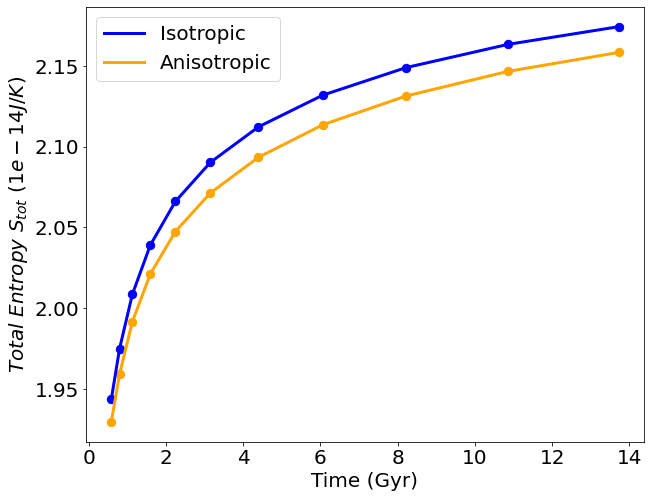

In [7]:
plt.figure(figsize=(10,8))

plt.plot(Store[:,0],Stot_iso*1e+14,label='Isotropic',linewidth=3,color='blue')
plt.scatter(Store[:,0],Stot_iso*1e+14,s=70,color='blue')
plt.plot(Store[:,0],Stot_ani*1e+14,label='Anisotropic',linewidth=3,color='orange')
plt.scatter(Store[:,0],Stot_ani*1e+14,s=70,color='orange')

plt.xlabel('Time (Gyr)',fontsize=20)
plt.ylabel('$Total\\ Entropy\\ S_{tot}\\ (1e-14 J/K)$',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
#plt.title('Time evolution of total entropy')
plt.savefig("Time evolution S.pdf",pad_inches=0.0)

In [8]:
Mpc=pynbody.array.SimArray(np.zeros(1))
Mpc[0]=1
Mpc.sim=f10
Mpc.units='Mpc'

sv_bar=np.zeros((11,2))
for i in range(11):
    totalV=(Store[i,1]*float(Mpc.in_units('m')))**3
    sv_bar[i,0]=Stot_iso[i]/totalV
    sv_bar[i,1]=Stot_ani[i]/totalV

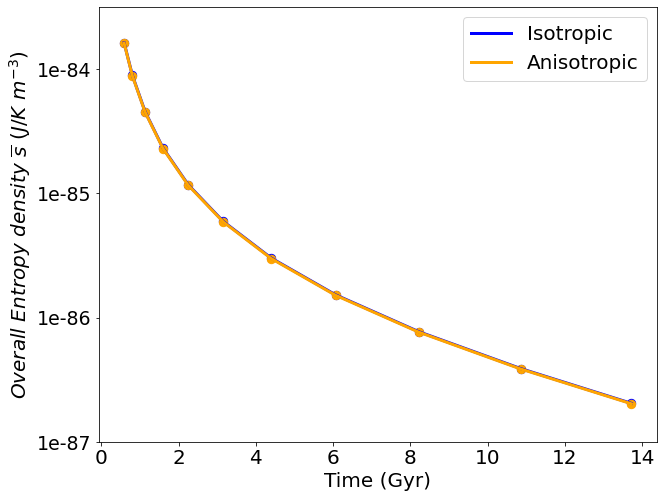

In [10]:
plt.figure(figsize=(10,8))

plt.plot(Store[:,0],np.log10(sv_bar[:,0]),label='Isotropic',linewidth=3,color='blue')
plt.scatter(Store[:,0],np.log10(sv_bar[:,0]),s=70,color='blue')
plt.plot(Store[:,0],np.log10(sv_bar[:,1]),label='Anisotropic',linewidth=3,color='orange')
plt.scatter(Store[:,0],np.log10(sv_bar[:,1]),s=70,color='orange')

plt.xlabel('Time (Gyr)',fontsize=20)
plt.ylabel('$Overall\\ Entropy\\ density\\ \overline{s}\\ (J/K\\ m^{-3})$',fontsize=20)
plt.yticks([-87,-86,-85,-84],['1e-87','1e-86','1e-85','1e-84'],fontsize=19)
plt.xticks(fontsize=20)
plt.ylim([-87,-83.5])
plt.legend(fontsize=20)
#plt.title('Time evolution of total entropy')
plt.savefig("Time evolution sv.pdf")

In [24]:
import matplotlib.ticker as ticker
res=2000
rhoplot00=pynbody.plot.image(f00, qty='rho',units='kg m**-3',resolution=res, width=f00.properties['boxsize'],denoise=True,threaded=False,noplot=True)
rhoplot10=pynbody.plot.image(f10, qty='rho',units='kg m**-3',resolution=res, width=f10.properties['boxsize'],denoise=True,threaded=False,noplot=True)

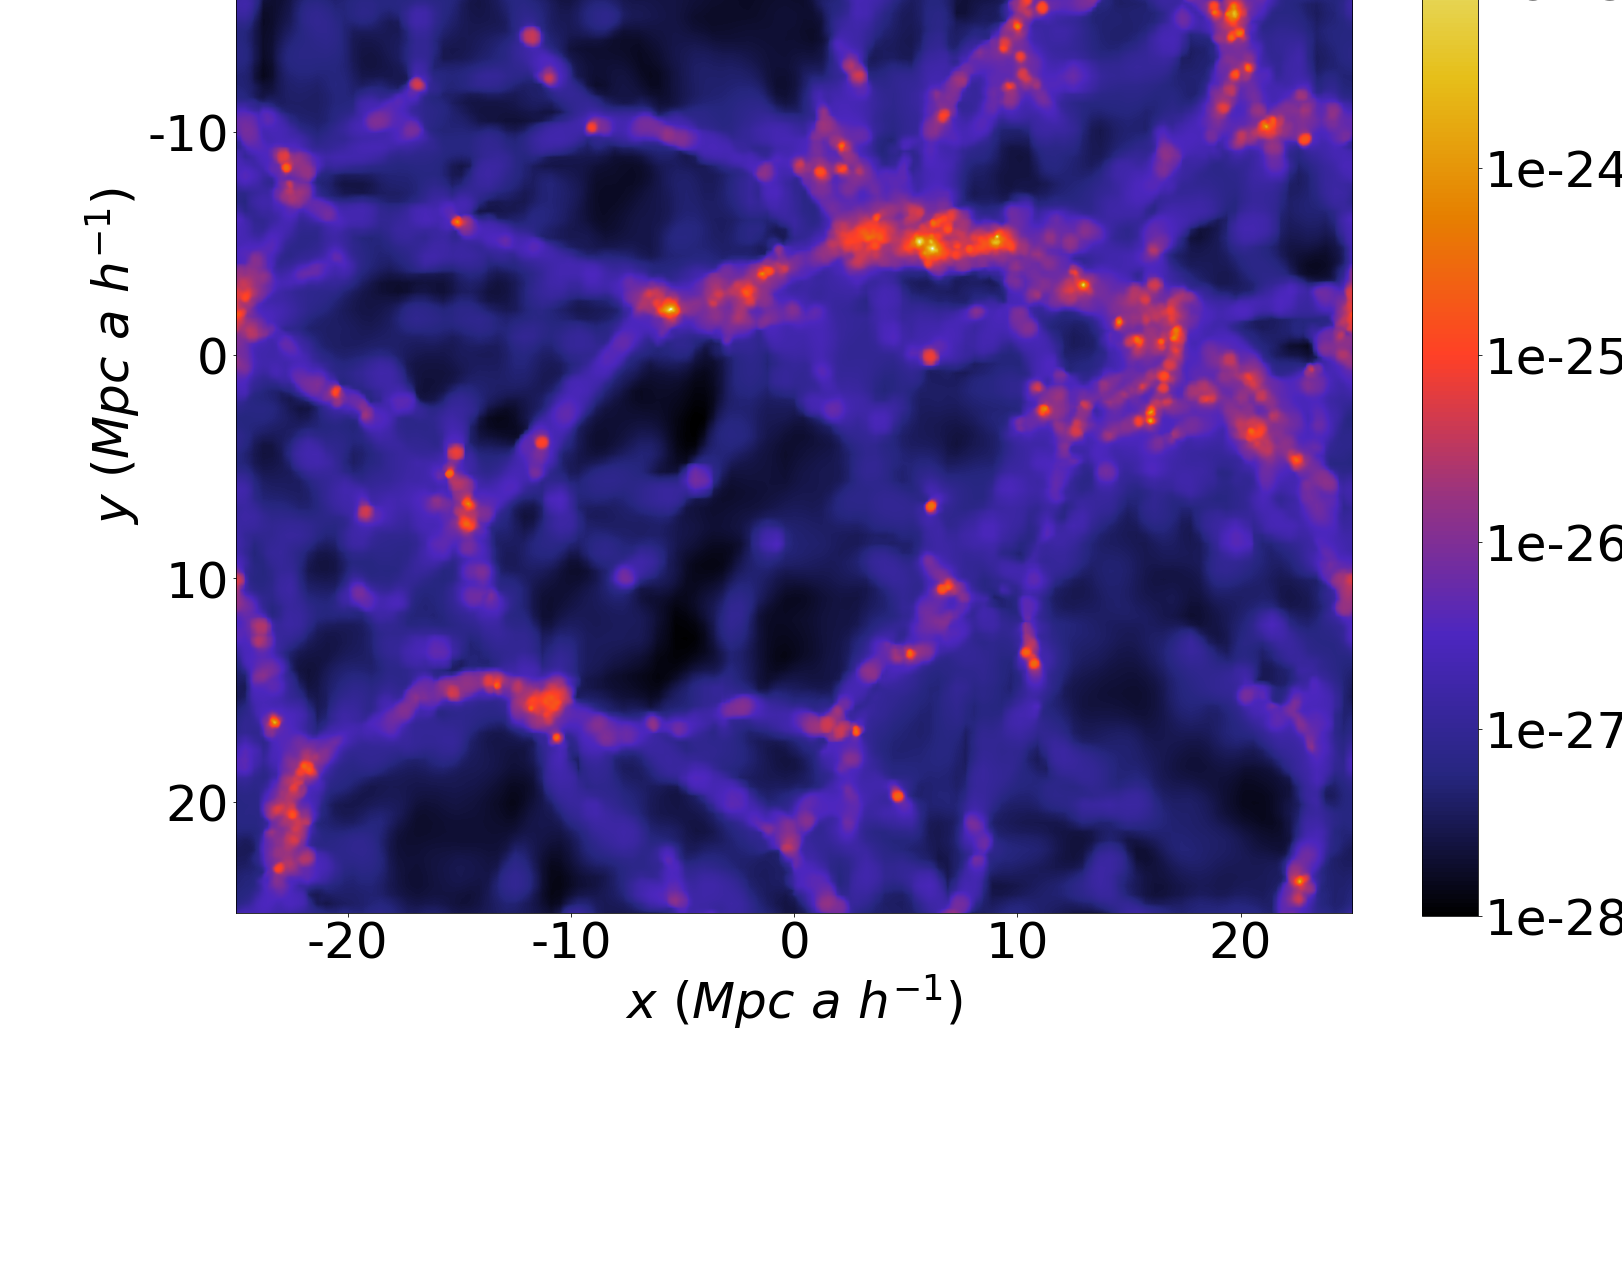

In [26]:
def cb(x,pos):
        return 10**x

plt.figure(figsize=(25,25))
plt.subplot(111)
plt.imshow(np.log10(rhoplot10),cmap='CMRmap',vmin=-28,vmax=-22)
cbr=plt.colorbar(shrink=0.825,format=ticker.FuncFormatter(cb))
plt.xticks([int(res/10),int(res*3/10),int(res/2),int(res*7/10),int(res*9/10)],['-20','-10','0','10','20'],fontsize=50)
plt.yticks([int(res/10),int(res*3/10),int(res/2),int(res*7/10),int(res*9/10)],['-20','-10','0','10','20'],fontsize=50)
plt.xlabel('$x\\ (Mpc\\ a\\ h^{-1})$',fontsize=50)
plt.ylabel('$y\\ (Mpc\\ a\\ h^{-1})$',fontsize=50)

cbr.set_label('$Density\\ (kg\\ m^{-3})$',fontsize=50)
cbr.ax.tick_params(labelsize=50)

plt.savefig('Density10.pdf',bbox_inches='tight',pad_inches=0.0)

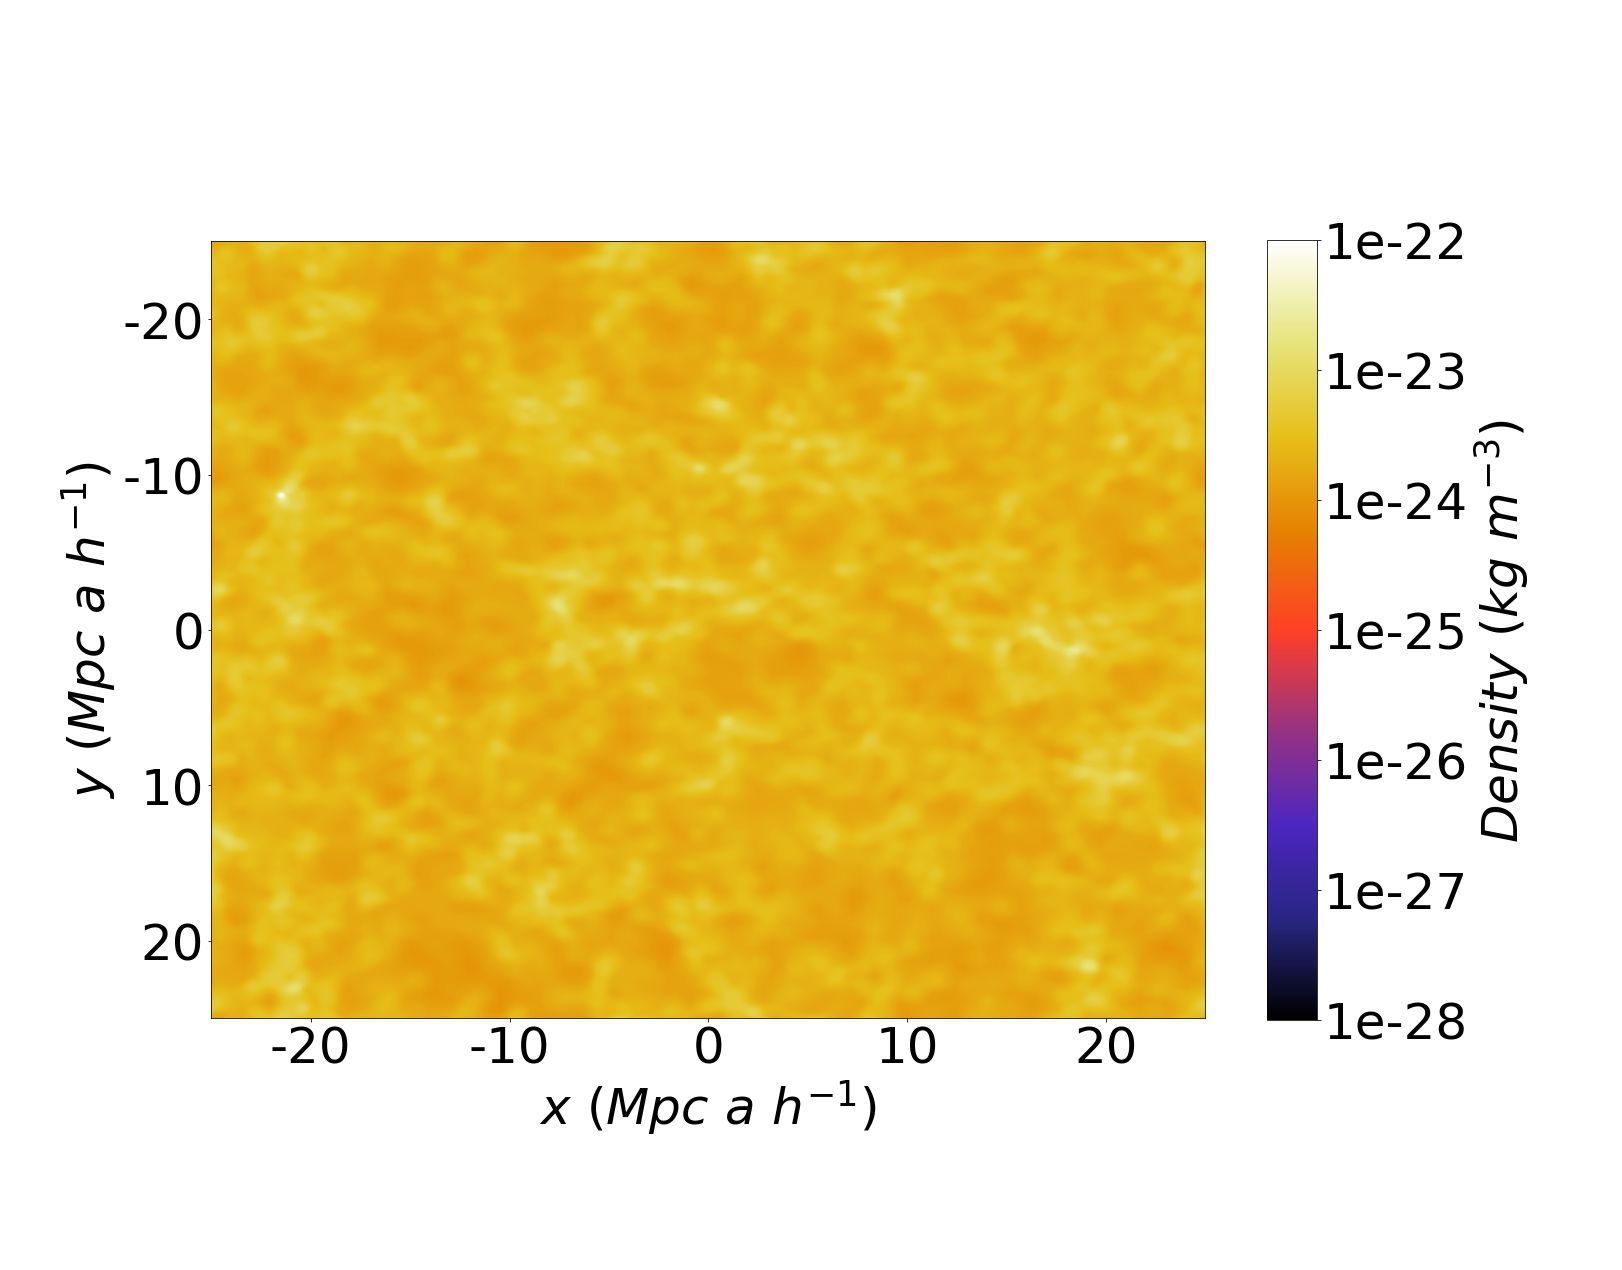

In [28]:
def cb(x,pos):
        return 10**x

plt.figure(figsize=(25,25))
plt.subplot(111)
plt.imshow(np.log10(rhoplot00),cmap='CMRmap',vmin=-28,vmax=-22)
cbr=plt.colorbar(shrink=0.825,format=ticker.FuncFormatter(cb))
plt.xticks([int(res/10),int(res*3/10),int(res/2),int(res*7/10),int(res*9/10)],['-20','-10','0','10','20'],fontsize=50)
plt.yticks([int(res/10),int(res*3/10),int(res/2),int(res*7/10),int(res*9/10)],['-20','-10','0','10','20'],fontsize=50)
plt.xlabel('$x\\ (Mpc\\ a\\ h^{-1})$',fontsize=50)
plt.ylabel('$y\\ (Mpc\\ a\\ h^{-1})$',fontsize=50)

cbr.set_label('$Density\\ (kg\\ m^{-3})$',fontsize=50)
cbr.ax.tick_params(labelsize=50)

plt.savefig('Density00.pdf',bbox_inches='tight',pad_inches=0.0)

In [37]:
for i in range(11):
    print(f[10].properties['a']/f[i].properties['a']-1)

8.63623227871074
6.832829791063014
5.222019779339949
3.9424705373714586
2.9260586866597436
2.1186704759825683
1.4773204454087399
0.967863112343281
0.5631749494966314
0.2417103031440715
0.0


In [41]:
for i in range(11):
    print(f[i].properties['a'])

0.10377499950984916
0.12766778120736963
0.16071951479814847
0.20232796380650292
0.2547083678086307
0.3206494587040138
0.4036619492860992
0.5081654276293767
0.6397236600561034
0.8053408250442559
0.9999999999999996
